In [1]:
# 商业智能与推荐系统

In [2]:
"""
	GBDT+LR算法Demo演示
	随机生成二分类样本8万个，每个样本20个特征
	采用RF，RF+LR，GBDT，GBDT+LR进行二分类预测
"""

import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10

In [3]:
# 生成样本集，二分类样本生成
X, y = make_classification(n_samples=80000, n_features=20)
#y1 = [x for x in y if x == 1]
#print(X)
#print(len(y1))

In [4]:
# 将样本集分成测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [5]:
# 再将训练集拆成两个部分（GBDT/RF，LR）
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

In [6]:
# 基于随机森林的监督变换 rf+lr （特征数量越多，喂给LR的特征越多，参数量越大 => 理论上模型的上限越高）
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [7]:
# 得到OneHot编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train)) 

OneHotEncoder()

In [8]:
# 使用OneHot编码作为特征，训练LR
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [9]:
# Step1, 使用中间的2万个样本，先进行RF => onehot
# Step2, 把生成的特征 onehot特征 进行LR训练
#print(rf_enc.transform(rf.apply(X_train_lr)))
# GBDT 将原始的20维特征 => 2万特征
temp = rf.apply(X_train_lr)
print('temp=\n', temp)
print('len(temp[0])=', len(temp[0]))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

temp=
 [[14  6  7 ... 14 10 10]
 [14  6  7 ... 14 10 10]
 [11  6  3 ...  6 11 10]
 ...
 [11  6  3 ...  6 11 10]
 [10  6  3 ...  3 11 10]
 [14  6  7 ... 14 10 10]]
len(temp[0])= 10


LogisticRegression(max_iter=1000)

In [10]:
# 使用LR进行预测
# Step1，先进行RF => onehot
# Step2，把生成的特征 onehot 进行LR预测
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [11]:
# 基于GBDT监督变换，gbdt+lr
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(X_train, y_train) # 前两万个样本
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')

In [12]:
#temp = grd.apply(X_train)
#np.set_printoptions(threshold=np.inf)  
grd_enc.fit(grd.apply(X_train)[:, :, 0])
#print(grd_enc.get_feature_names()) # 查看每一列对应的特征

OneHotEncoder()

In [13]:
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

LogisticRegression(max_iter=1000)

In [14]:
# 使用LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

In [15]:
# 直接使用GBDT进行预测
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

In [16]:
# 直接使用RF进行预测
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(y_test, y_pred_rf)

In [17]:
# 直接使用LR进行预测
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
#auc = roc_auc_score(Y_test, Y_pred)
#print('LogisticRegression: ', auc)

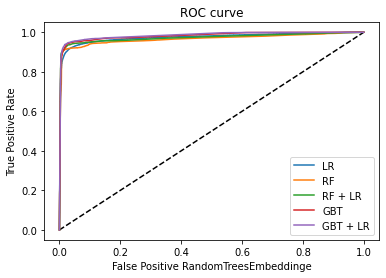

In [18]:
#print(fpr_rf,'\n', tpr_rf,'\n', thresholds_skl)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive RandomTreesEmbeddinge')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

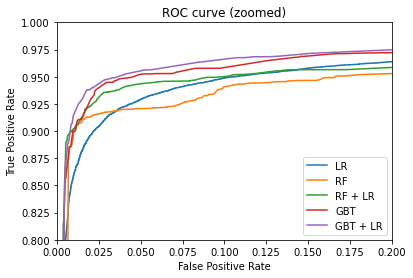

In [19]:
# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()